In [1]:
#importing stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
from scipy import fft 
%matplotlib notebook

In [2]:
# what are we doing? we are trying to get the heart rate (HR) and resipiratory rate (RR)
# how are we going to do this?
# using two techniques, SCG and BCG, that need
# info about the mechanical properties of the human body such as acceleration, angular velocity

# first things first, we load the center_sternum dataset and add a time column as index
df=pd.read_csv("center_sternum.txt",sep=None,engine='python')
df['time_s'] = np.arange(0,df.shape[0])/200 # let's construct the time axis, with each sampling separated by a 200th of a second (because sampling rate is 200 Hz)
df=df.set_index('time_s')
df

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
time_s,,,,,,,,,,,,,,,,
0.000,5,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178,0.792622,0.254952,-0.553850,-0.000031
0.005,5,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177,0.736461,0.275124,-0.617969,0.006806
0.010,5,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177,0.729465,0.275246,-0.626118,0.009827
0.015,5,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176,0.723413,0.277200,-0.632221,0.011383
0.020,5,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176,0.721948,0.280007,-0.632679,0.010193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82.505,5,200,1576222847,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126,0.650810,0.379162,-0.636402,0.166356
82.510,5,200,1576222847,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125,0.650239,0.379803,-0.636708,0.165960
82.515,5,200,1576222847,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125,0.649365,0.380627,-0.637227,0.165502


In [3]:
#drop some columns 
new_df=df.drop(columns=['Log Mode','Log Freq','Timestamp','MagnX','MagnY','MagnZ','qw','qi','qj','qk'])
new_df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
time_s,,,,,,
0.000,947.086,435.662,70.638,-6.824428,-14.244280,1.404580
0.005,969.168,387.777,88.877,6.183206,-12.290080,-7.969466
0.010,989.603,380.335,78.751,11.709920,-4.961832,-7.450382
0.015,954.894,418.033,88.328,17.877860,2.519084,-5.984733
0.020,972.096,427.732,99.857,25.221370,5.404580,4.015267
...,...,...,...,...,...,...
82.505,958.493,291.092,-54.290,1.664122,2.305344,-0.671756
82.510,954.650,288.042,-49.654,1.480916,2.488550,-0.702290
82.515,967.338,290.482,-63.867,1.114504,3.374046,-0.900763


<IPython.core.display.Javascript object>


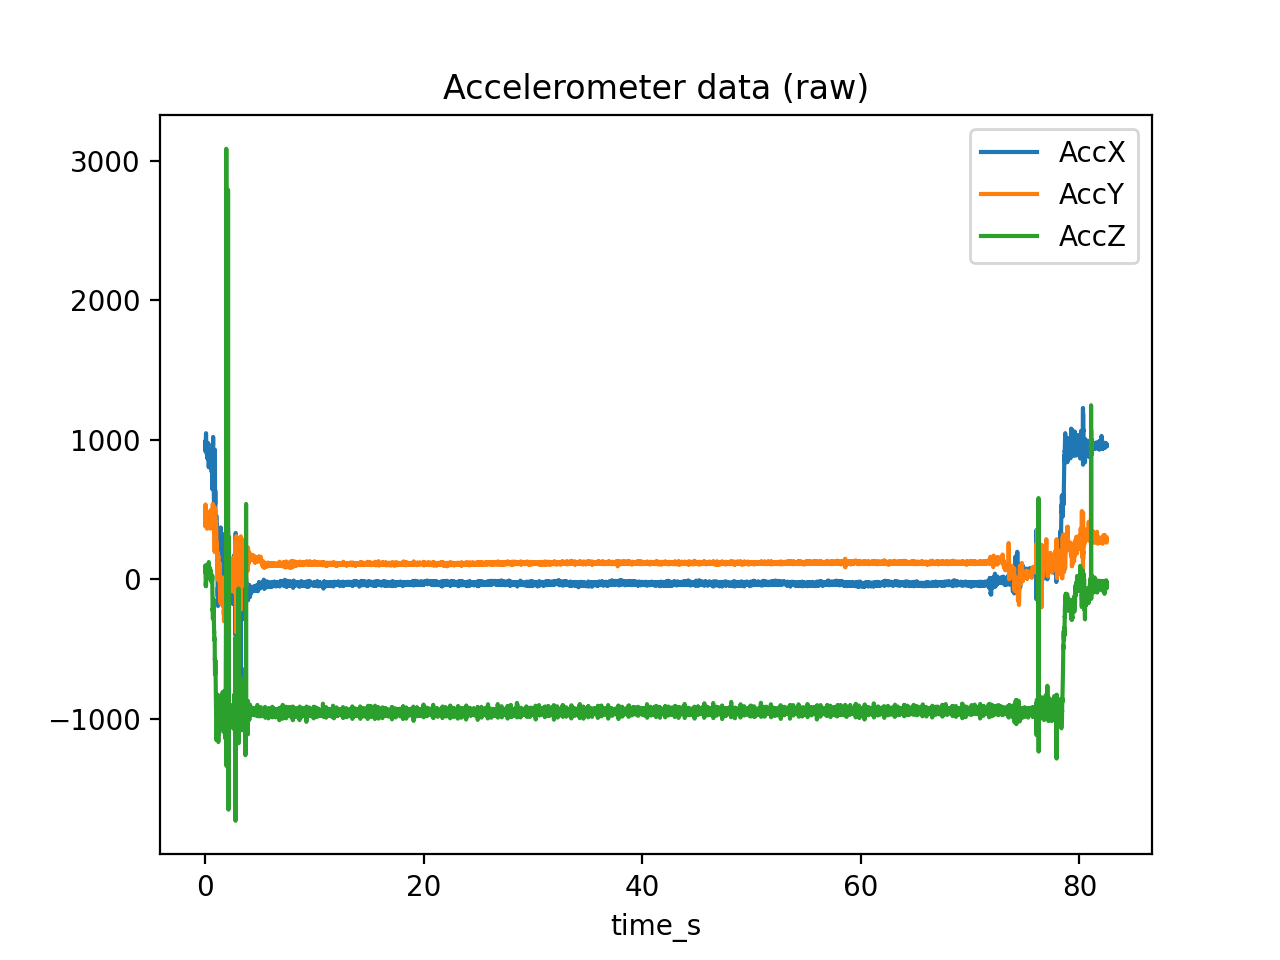

<IPython.core.display.Javascript object>


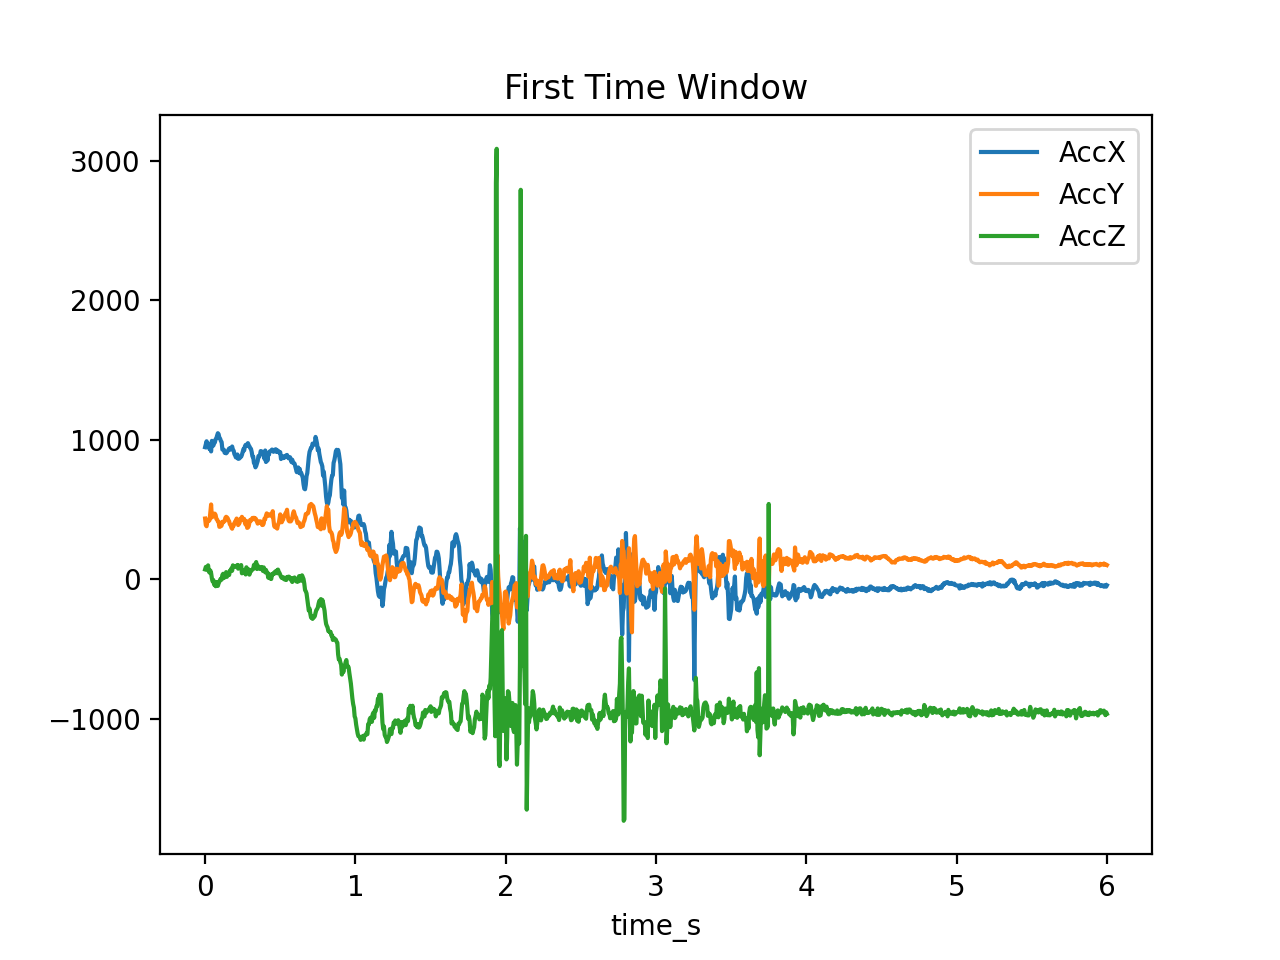

<IPython.core.display.Javascript object>


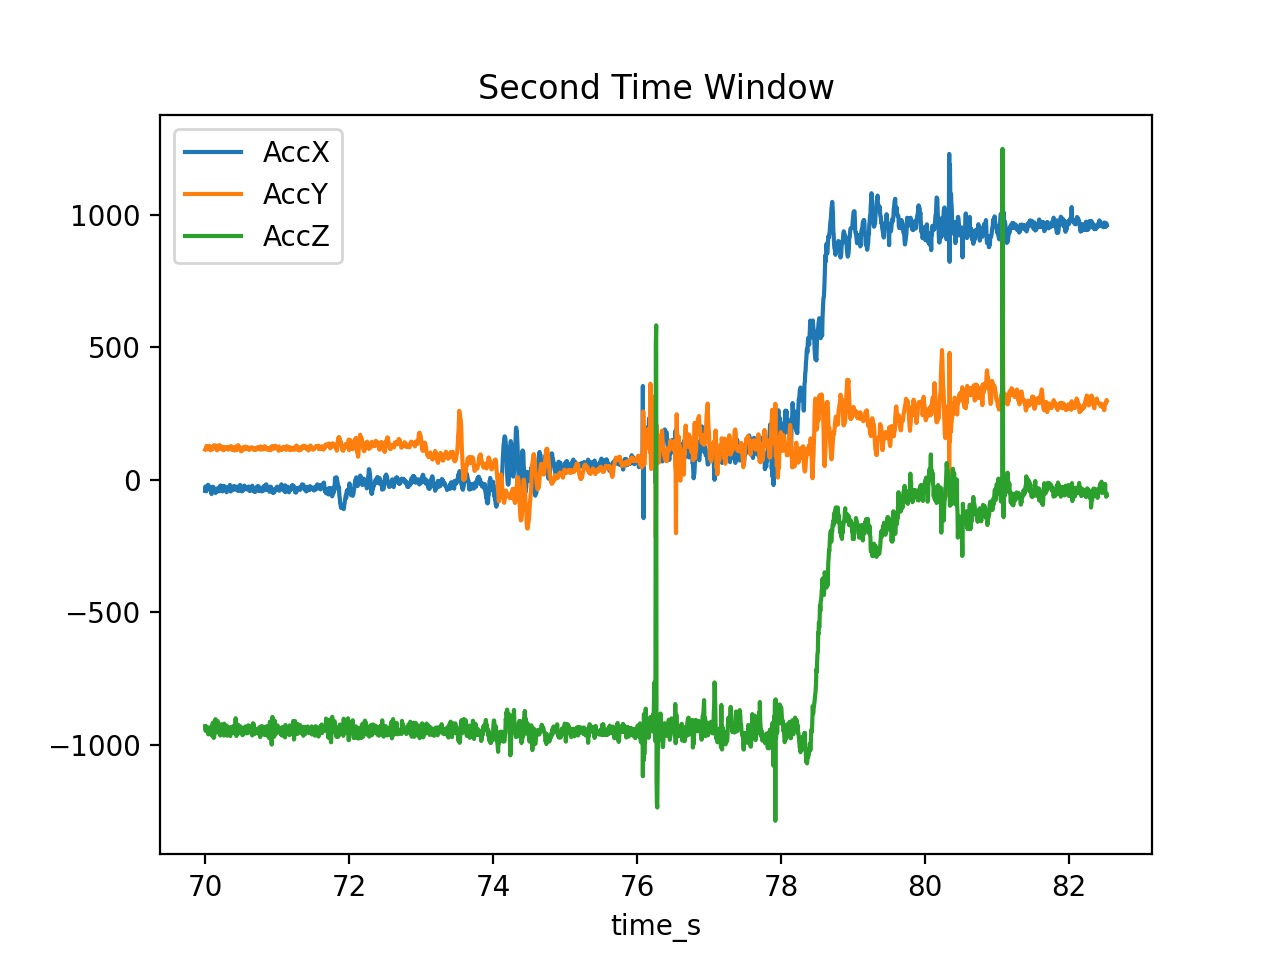

<AxesSubplot:title={'center':'Second Time Window'}, xlabel='time_s'>

In [4]:
# now let's look at the acceleration vector by plotting its three components
new_df.plot(y=['AccX','AccY','AccZ'], title= 'Accelerometer data (raw)')
new_df.loc[0:6].plot(y=['AccX','AccY','AccZ'],title='First Time Window')
new_df.loc[70:].plot(y=['AccX','AccY','AccZ'],title='Second Time Window')

In [5]:
#clean up the data (we select a time intervall from 10s to 70s)
data=new_df.loc[10:70].copy()

data

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
time_s,,,,,,
10.000,-32.635,112.911,-953.796,1.755725,5.022901,-0.809160
10.005,-19.154,112.362,-971.608,1.557252,4.198473,-1.083969
10.010,-27.450,110.593,-944.280,0.931298,4.320611,-1.099237
10.015,-21.777,113.948,-940.803,0.946565,4.137404,-1.267176
10.020,-32.391,118.218,-924.394,1.022901,4.702290,-0.992366
...,...,...,...,...,...,...
69.980,-30.866,118.767,-941.108,-3.175573,3.358779,-0.778626
69.985,-32.818,118.279,-942.145,-2.992366,3.679389,-0.549618
69.990,-22.692,113.704,-948.184,-3.022901,3.786260,-0.564886


<IPython.core.display.Javascript object>


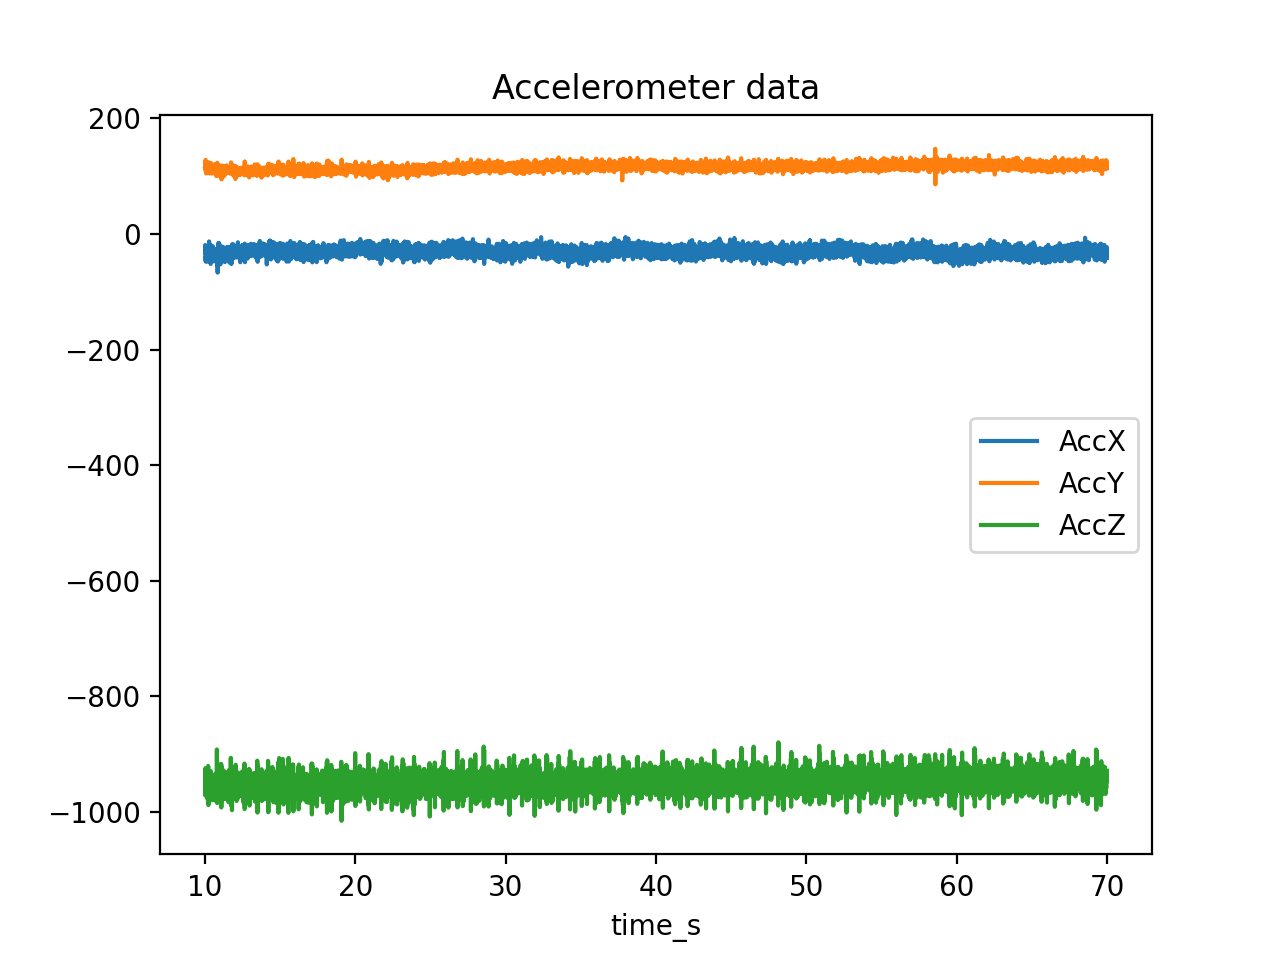

<AxesSubplot:title={'center':'Accelerometer data'}, xlabel='time_s'>

In [6]:
data.plot(y=['AccX','AccY','AccZ'],title= 'Accelerometer data')

In [7]:
#set the offset to 0
data['AccX']=data['AccX']-data['AccX'].mean()
data['AccY']=data['AccY']-data['AccY'].mean()
data['AccZ']=data['AccZ']-data['AccZ'].mean()
data['GyroX']=data['GyroX']-data['GyroX'].mean()
data['GyroY']=data['GyroY']-data['GyroY'].mean()
data['GyroZ']=data['GyroZ']-data['GyroZ'].mean()

data

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
time_s,,,,,,
10.000,-1.964316,-2.663297,-4.702662,3.840297,1.340126,0.059527
10.005,11.516684,-3.212297,-22.514662,3.641824,0.515698,-0.215282
10.010,3.220684,-4.981297,4.813338,3.015870,0.637836,-0.230550
10.015,8.893684,-1.626297,8.290338,3.031137,0.454629,-0.398489
10.020,-1.720316,2.643703,24.699338,3.107473,1.019515,-0.123679
...,...,...,...,...,...,...
69.980,-0.195316,3.192703,7.985338,-1.091001,-0.323996,0.090061
69.985,-2.147316,2.704703,6.948338,-0.907794,-0.003386,0.319069
69.990,7.978684,-1.870297,0.909338,-0.938329,0.103485,0.303802


In [8]:
data.describe()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
count,1.200100e+04,1.200100e+04,1.200100e+04,1.200100e+04,1.200100e+04,1.200100e+04
mean,2.034351e-15,-4.267638e-14,-2.856021e-12,9.416497e-16,-7.915083e-15,-2.895581e-15
std,7.005840e+00,5.328624e+00,1.439820e+01,1.412966e+00,7.127012e-01,3.629598e-01
min,-3.624632e+01,-2.974730e+01,-6.643466e+01,-7.915428e+00,-3.178958e+00,-1.635130e+00
25%,-4.587316e+00,-3.517297e+00,-8.545662e+00,-6.024512e-01,-4.003316e-01,-2.305498e-01
50%,4.868411e-02,1.427027e-01,-4.326624e-01,-6.810016e-02,-4.918656e-02,1.372536e-02
75%,4.684684e+00,3.497703e+00,7.802338e+00,6.036558e-01,3.172254e-01,2.427330e-01
max,2.524168e+01,3.180170e+01,6.935134e+01,6.557854e+00,3.874477e+00,1.509909e+00


<IPython.core.display.Javascript object>


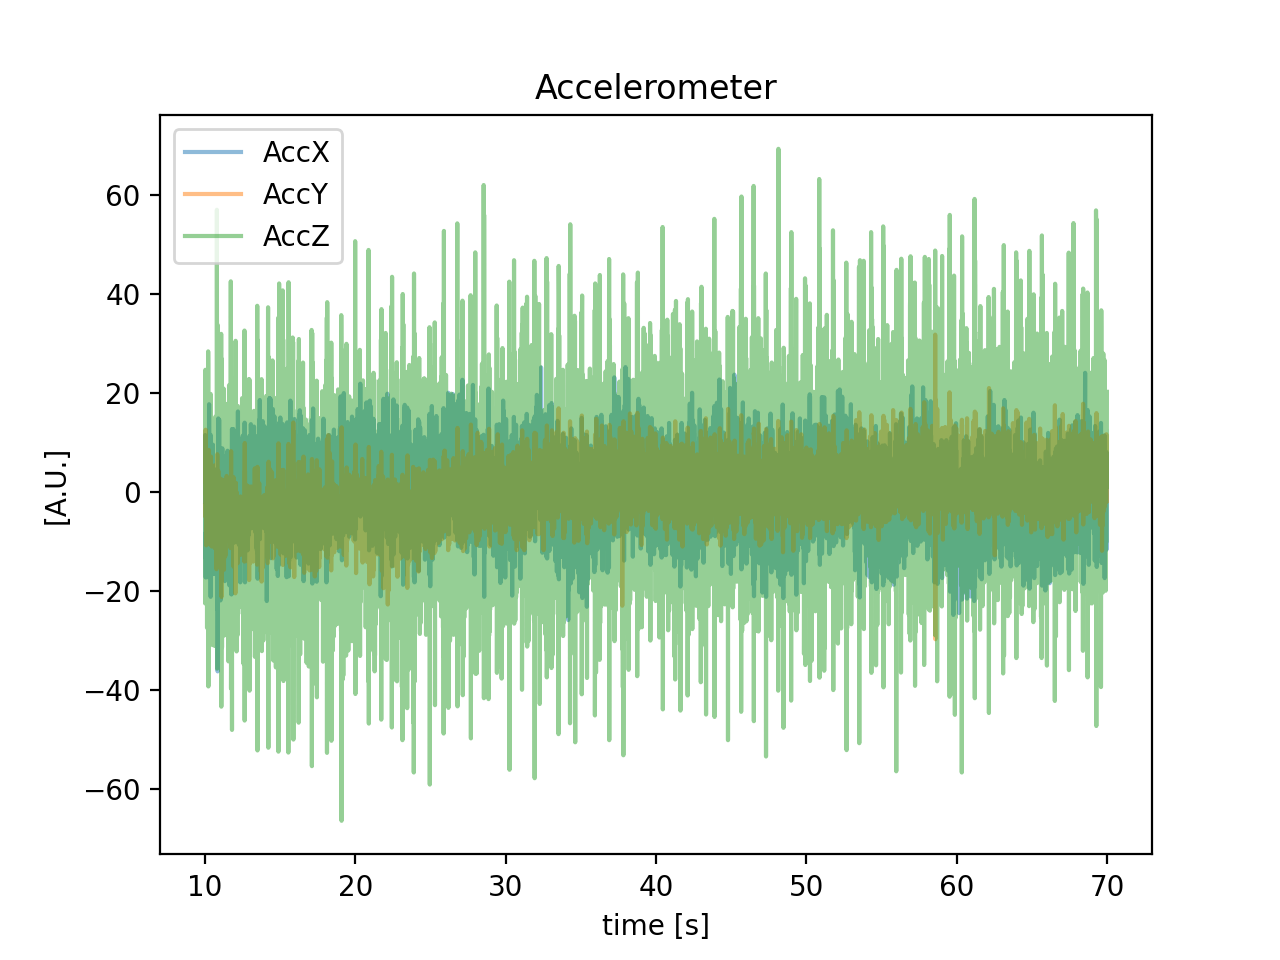

<IPython.core.display.Javascript object>


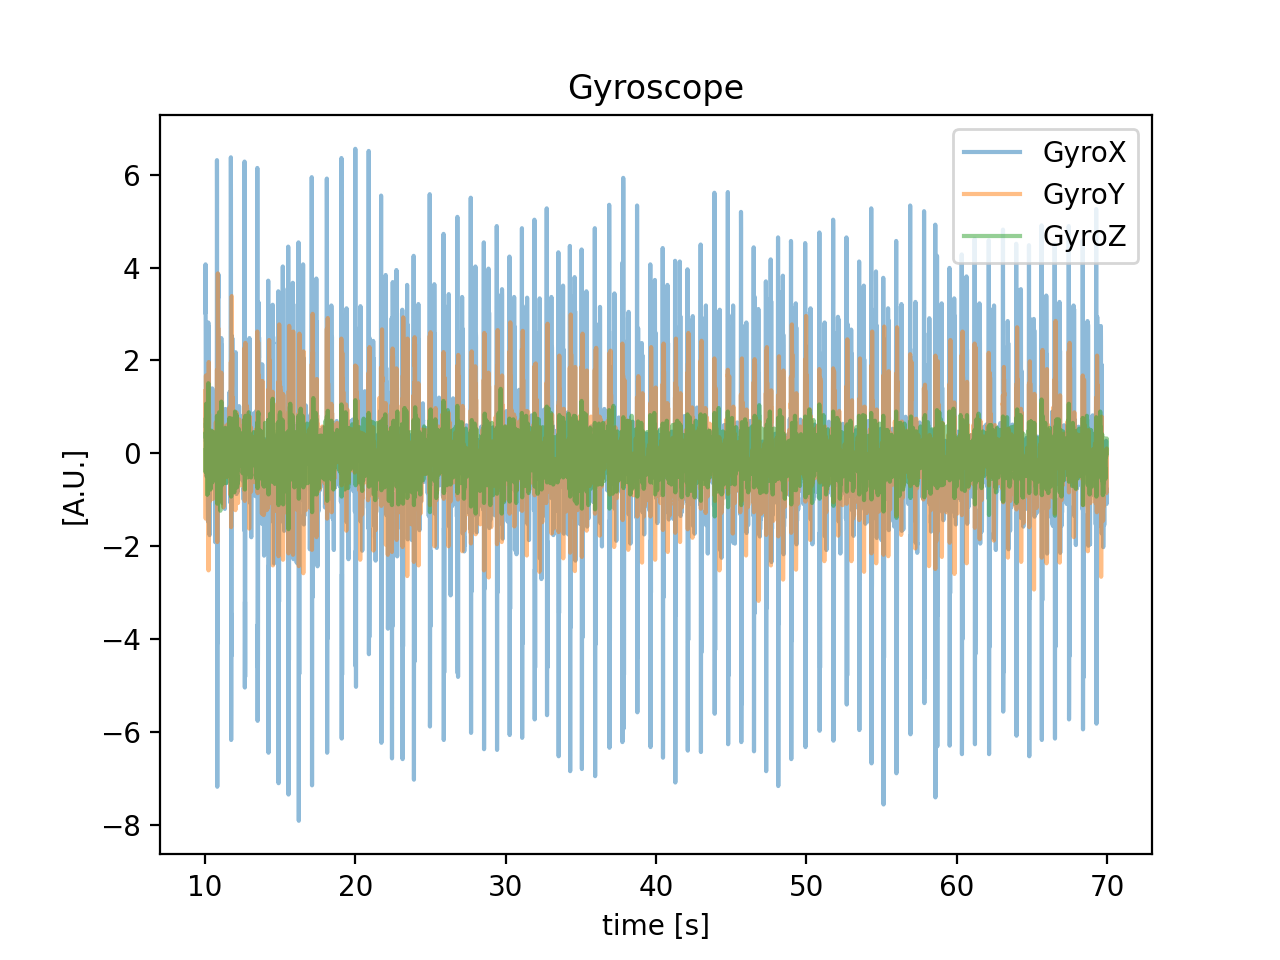

<AxesSubplot:title={'center':'Gyroscope'}, xlabel='time [s]', ylabel='[A.U.]'>

In [9]:
data.plot(y=['AccX','AccY','AccZ'],alpha=0.5, title='Accelerometer',ylabel='[A.U.]', xlabel='time [s]')
data.plot(y=['GyroX','GyroY','GyroZ'],alpha=0.5, title='Gyroscope',ylabel='[A.U.]', xlabel='time [s]')

Contributions to variance along the three eigenvectors' direction:
[0.76  0.139 0.092 0.007 0.001 0.   ]


<IPython.core.display.Javascript object>


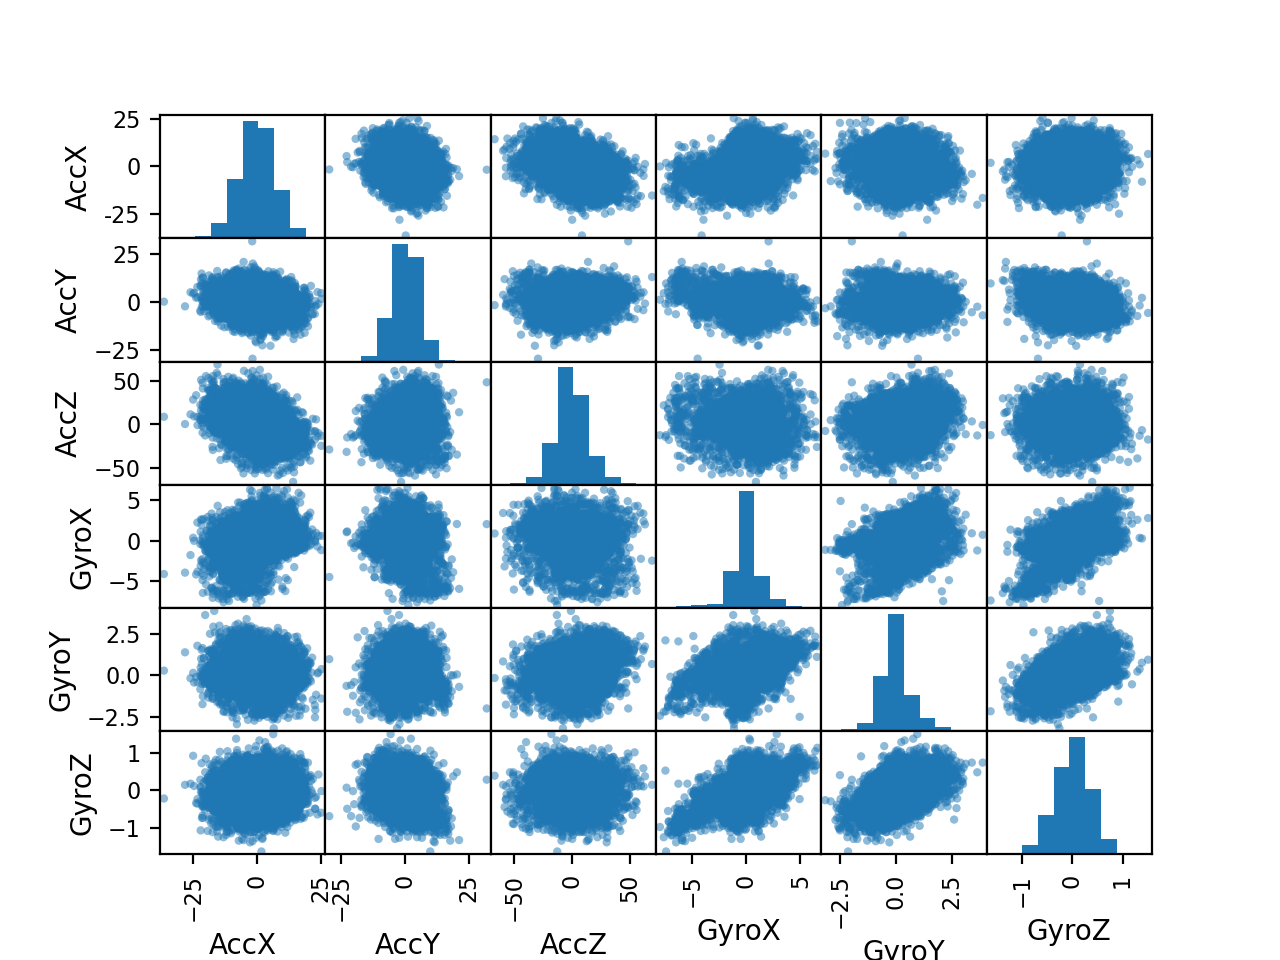

<IPython.core.display.Javascript object>


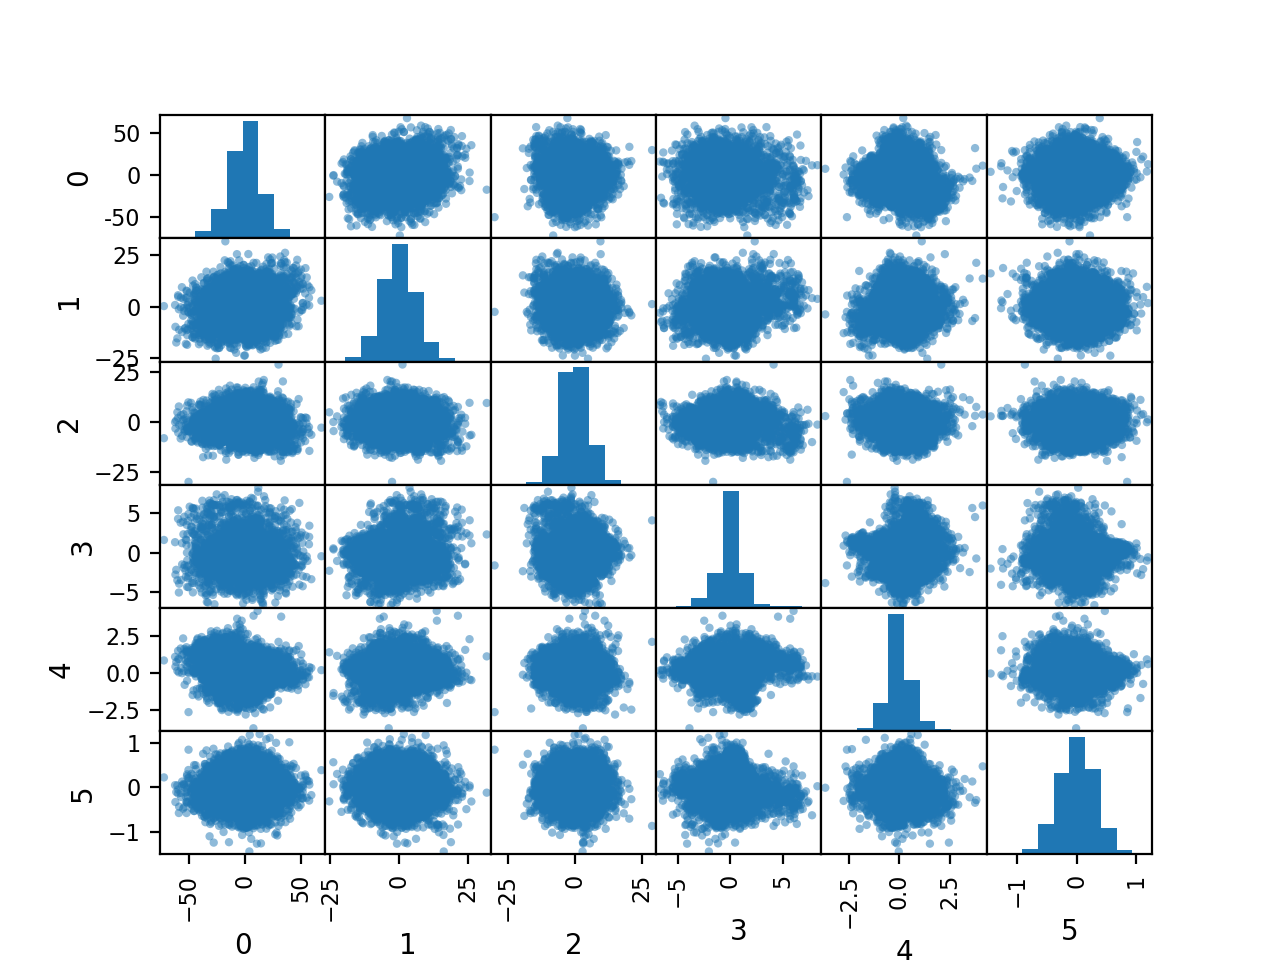

array([[<AxesSubplot:xlabel='0', ylabel='0'>,
        <AxesSubplot:xlabel='1', ylabel='0'>,
        <AxesSubplot:xlabel='2', ylabel='0'>,
        <AxesSubplot:xlabel='3', ylabel='0'>,
        <AxesSubplot:xlabel='4', ylabel='0'>,
        <AxesSubplot:xlabel='5', ylabel='0'>],
       [<AxesSubplot:xlabel='0', ylabel='1'>,
        <AxesSubplot:xlabel='1', ylabel='1'>,
        <AxesSubplot:xlabel='2', ylabel='1'>,
        <AxesSubplot:xlabel='3', ylabel='1'>,
        <AxesSubplot:xlabel='4', ylabel='1'>,
        <AxesSubplot:xlabel='5', ylabel='1'>],
       [<AxesSubplot:xlabel='0', ylabel='2'>,
        <AxesSubplot:xlabel='1', ylabel='2'>,
        <AxesSubplot:xlabel='2', ylabel='2'>,
        <AxesSubplot:xlabel='3', ylabel='2'>,
        <AxesSubplot:xlabel='4', ylabel='2'>,
        <AxesSubplot:xlabel='5', ylabel='2'>],
       [<AxesSubplot:xlabel='0', ylabel='3'>,
        <AxesSubplot:xlabel='1', ylabel='3'>,
        <AxesSubplot:xlabel='2', ylabel='3'>,
        <AxesSubplot:xlabel='3'

In [10]:
#PCA

c=data[['AccX','AccY','AccZ','GyroX','GyroY','GyroZ']].cov()
l,V=la.eig(c) #V[:,i] is the normalized eigenvector corresponding to the l[i] eigenvalue 
l_r=np.real_if_close(l)
print("Contributions to variance along the three eigenvectors' direction:")
with np.printoptions(precision=3, suppress=True):
    print(l_r/c.values.trace()) 
data_acc_transf = (V.T @ data[['AccX','AccY','AccZ','GyroX','GyroY','GyroZ']].T).T

pd.plotting.scatter_matrix(data[['AccX','AccY','AccZ','GyroX','GyroY','GyroZ']])
pd.plotting.scatter_matrix(data_acc_transf)

<IPython.core.display.Javascript object>


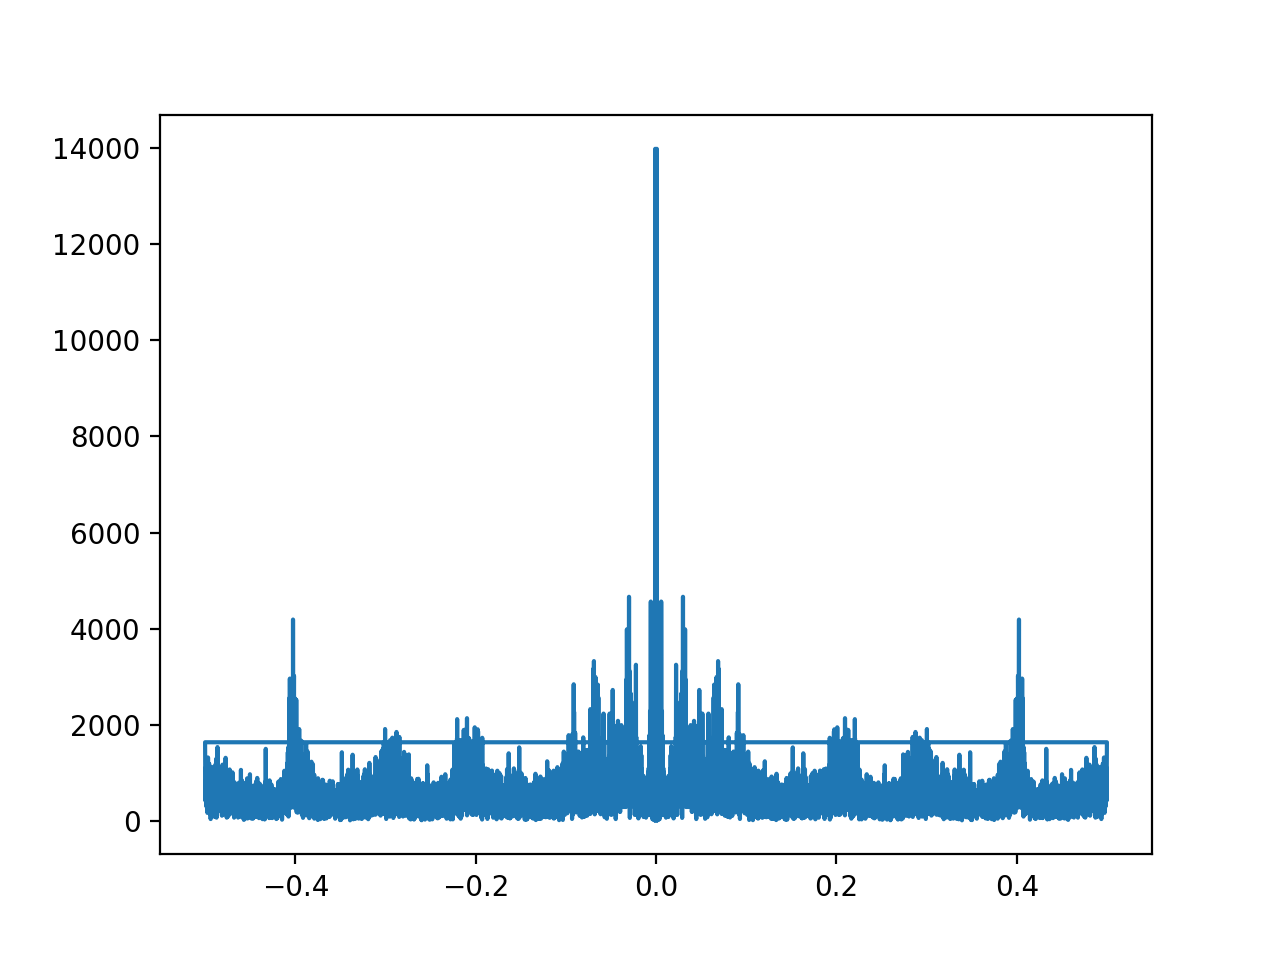

Peak frequency: 0.0008332638946754438
Period: 1200.1


In [11]:
accX=data['AccX'].values

fft_accX=fft.fft(accX)

time_step=1

accX_freq = fft.fftfreq(accX.size, d=time_step)

power_accX = np.abs(fft_accX)

fig, ax = plt.subplots()
ax.plot(accX_freq, power_accX)


peak_accX = accX_freq[power_accX.argmax()]

print("Peak frequency:", peak_accX)
period_accX=1/peak_accX
print("Period:", period_accX)




<IPython.core.display.Javascript object>


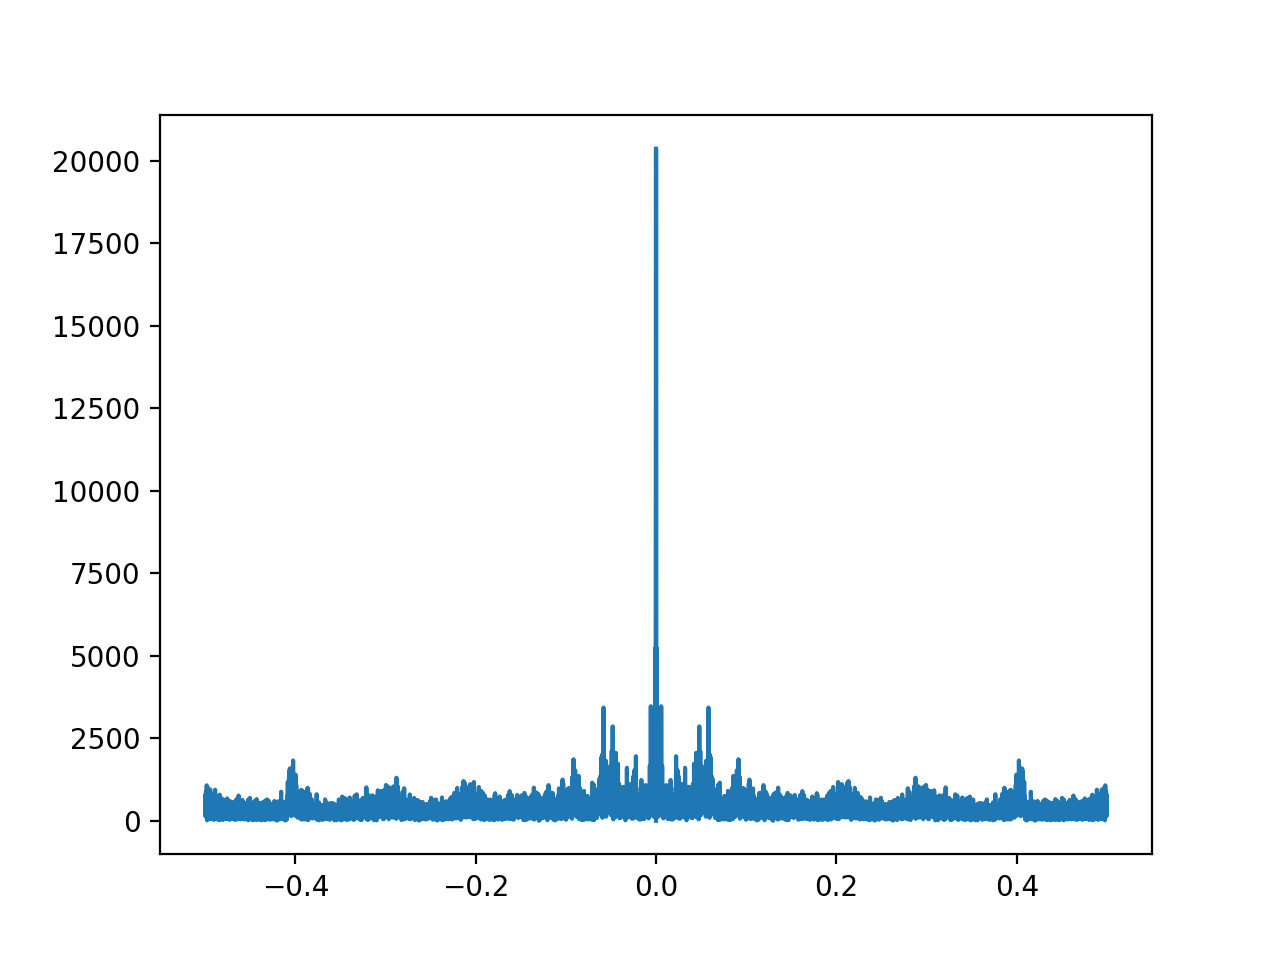

Peak frequency: 8.332638946754438e-05
Period: 12000.999999999998


In [12]:
accY=data['AccY'].values

fft_accY=fft.fft(accY)

time_step=1

accY_freq = fft.fftfreq(accY.size, d=time_step)

power_accY = np.abs(fft_accY)

fig, ax = plt.subplots()
ax.plot(accY_freq, power_accY)


peak_accY = accX_freq[power_accY.argmax()]

print("Peak frequency:", peak_accY)
period_accY=1/peak_accY
print("Period:", period_accY)



<IPython.core.display.Javascript object>


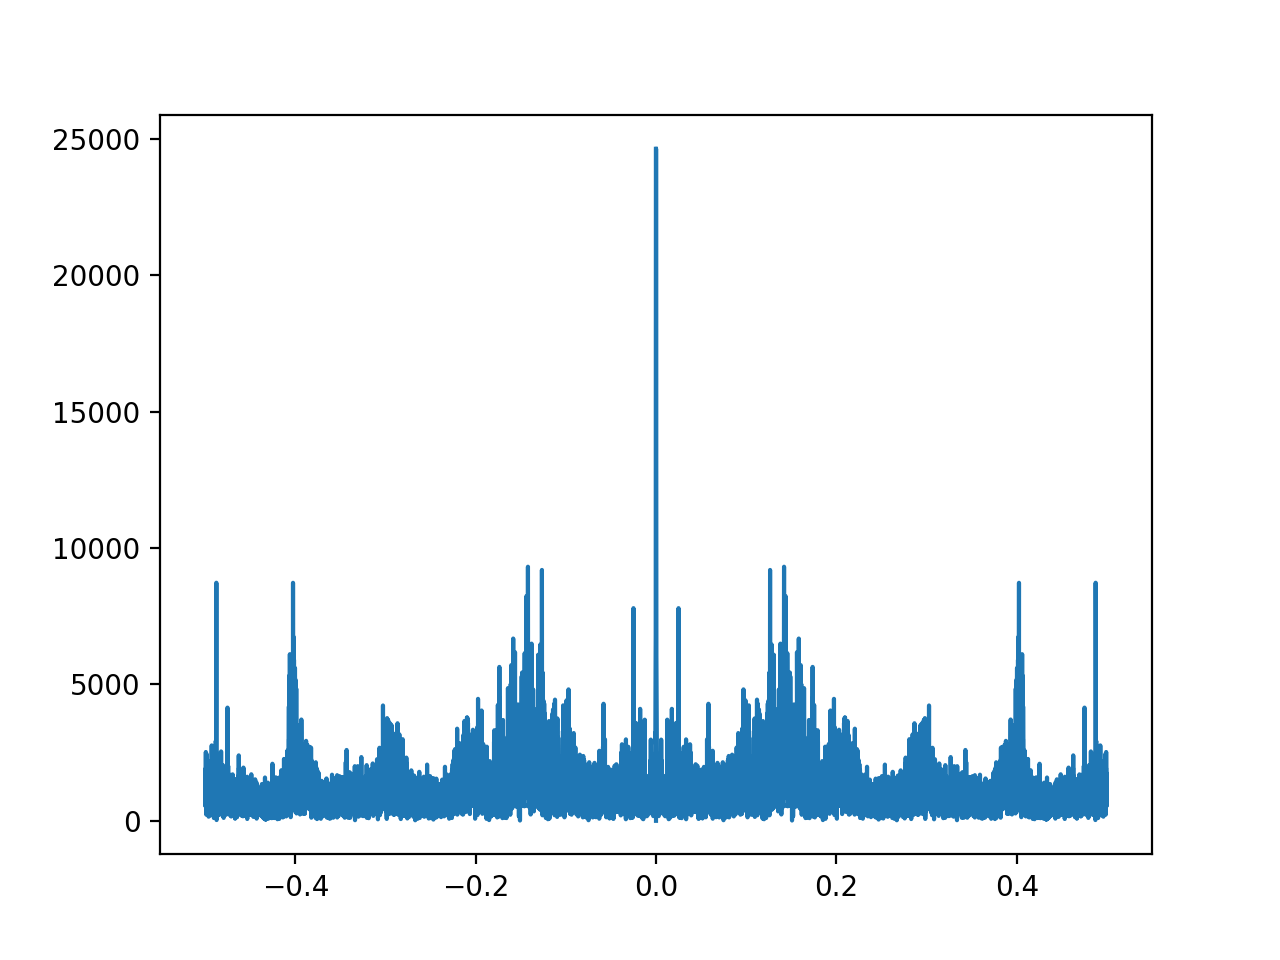

Peak frequency: 8.332638946754438e-05
Period: 12000.999999999998


In [13]:
accZ=data['AccZ'].values

fft_accZ=fft.fft(accZ)

time_step=1

accZ_freq = fft.fftfreq(accZ.size, d=time_step)

power_accZ = np.abs(fft_accZ)

fig, ax = plt.subplots()
ax.plot(accZ_freq, power_accZ)


peak_accZ = accZ_freq[power_accZ.argmax()]

print("Peak frequency:", peak_accZ)
period_accZ=1/peak_accZ
print("Period:", period_accZ)